In [1]:
import xarray as xr
import torch
from torch.nn import functional as F
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
from datetime import date
import json
import copy
from scipy.interpolate import RectBivariateSpline
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product

import climate_train as ct
import climate_data
import climate_models as cm
import climate_job_maintenance as cjm
root='/scratch/cg3306/climate/runs/'

In [2]:
def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

We are loading one of the neural networks that was tested.

This experiment is index 8000 for filter size testing.

Below we are picking 4th filter size, that is 5x5 input box size. 

The neural network takes in surface variables u,v,T with T standing for temperature.

Even though we have smaller kernels in the neural network, the total number of parameters has been kept the same with the original neural network GZ21.

In [3]:
args=ct.options(string_input="-b 3".split())
offset=8000
args.model_id=offset
args.model_bank_id="G"
C,names=cm.golden_model_bank(args,only_description=True,verbose=True)

filter size training 8000
	dataset
		surf - depth 110m - 
	filter sozes
		21 - 15 - 9 - 7 - 5 - 4 - 3 - 2 - 1 - 
	sigma
		4 - 8 - 12 - 16 - 
	residue
		yes - no - 


In [4]:
model_id=cjm.jobnums(C=C,x=[[0],[4],[0],[1]],offset=offset)[0]
args.model_id=model_id

Actually loading the neural network

In [5]:
net,criterion,(data_init,partition),logs,(PATH0,PATH1,LOG,root)=ct.load_from_save(args)
(training_set,training_generator),(val_set,val_generator),(test_set,test_generator),(dataset,glbl_gen)=ct.load_data(data_init,partition,args)

LCNN + 5x5 + surface + glbl + coarse(4) + batch= 2


/ext3/miniconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


domain id: 3
Loaded the existing model


Layers of the neural network

In [6]:
net.nn_layers

ModuleList(
  (0): Conv2d(3, 298, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(298, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Conv2d(298, 149, kernel_size=(2, 2), stride=(1, 1))
  (3): BatchNorm2d(149, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(149, 75, kernel_size=(2, 2), stride=(1, 1))
  (5): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(75, 75, kernel_size=(2, 2), stride=(1, 1))
  (7): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(75, 75, kernel_size=(1, 1), stride=(1, 1))
  (9): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Conv2d(75, 75, kernel_size=(1, 1), stride=(1, 1))
  (11): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Conv2d(75, 75, kernel_size=(1, 1), stride=(1, 1))
  (13): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=Tru

Creating a simple CNN class to show how the weights work in action

In [7]:
class CNN(nn.Module):
    def __init__(self,net_):
        super(CNN, self).__init__()
        self.nn_layers = net_.nn_layers
    def forward(self, x):
        cn=0
        while cn<len(self.nn_layers)-2:
            x = self.nn_layers[cn](x)
            cn+=1
            x = F.relu(self.nn_layers[cn](x))
            cn+=1
        x=self.nn_layers[cn](x)
        mean,precision=torch.split(x,x.shape[1]//2,dim=1)
        precision=self.nn_layers[-1](precision)
        x=torch.cat([mean,precision],dim=1)
        return x

In [8]:
cnn=CNN(net)

In [10]:
X,_,Y=training_set[0]
with torch.no_grad():
    Ypred0=net.forward(torch.stack([X],dim=0))[0]
    Ypred1=cnn.forward(torch.stack([X],dim=0))[0]

In [11]:
with torch.no_grad():
    Ypred0=net.forward(torch.stack([X],dim=0))[0]
    Ypred1=cnn.forward(torch.stack([X],dim=0))[0]

Checking the consistency 

In [12]:
torch.mean((Ypred1-Ypred0)**2).item()

0.0

Neural network inputs and outputs are normalized across each channel with the following weights

In [13]:
inscales=torch.tensor(training_set.inscales).reshape([-1,1,1])
outscales=torch.tensor(training_set.outscales).reshape([-1,1,1])

For illustration we chose a particular box on the surface of the ocean

The variables are rescaled to their true values. They are also flipped across latitude-axis because that is how they are stored in xarray originally. The neural networks act on them also in upside down configuration. So the neural network output is also upside down.

In [15]:
ilatmin,ilatmax=300,350
ilonmin,ilonmax=250,300

lons=training_set.ds_data.xu_ocean.values
lats=training_set.ds_data.yu_ocean.values

lons=lons[ilonmin:ilonmax]
lats=lats[ilatmin:ilatmax]

X_=X[:,ilatmin:ilatmax,ilonmin:ilonmax]*inscales
mean,precision=torch.split(Ypred1,Ypred1.shape[0]//2,dim=0)
mean_=mean[:,ilatmin:ilatmax,ilonmin:ilonmax]*outscales
precision_=precision[:,ilatmin:ilatmax,ilonmin:ilonmax]/outscales**2
Y_=Y[:,ilatmin:ilatmax,ilonmin:ilonmax]*outscales


img=[X_,mean_,Y_]
vmaxs=[[torch.amax(b).item() for b in a] for a in img]
vmaxs[1]=[np.maximum(vmaxs[1][i],vmaxs[2][i]) for i in range(len(vmaxs[1]))]
vmaxs[2]=vmaxs[1]

vmins=[[torch.amin(b).item() for b in a] for a in img]
vmins[1]=[np.minimum(vmins[1][i],vmins[2][i]) for i in range(len(vmins[1]))]
vmins[2]=vmins[1]

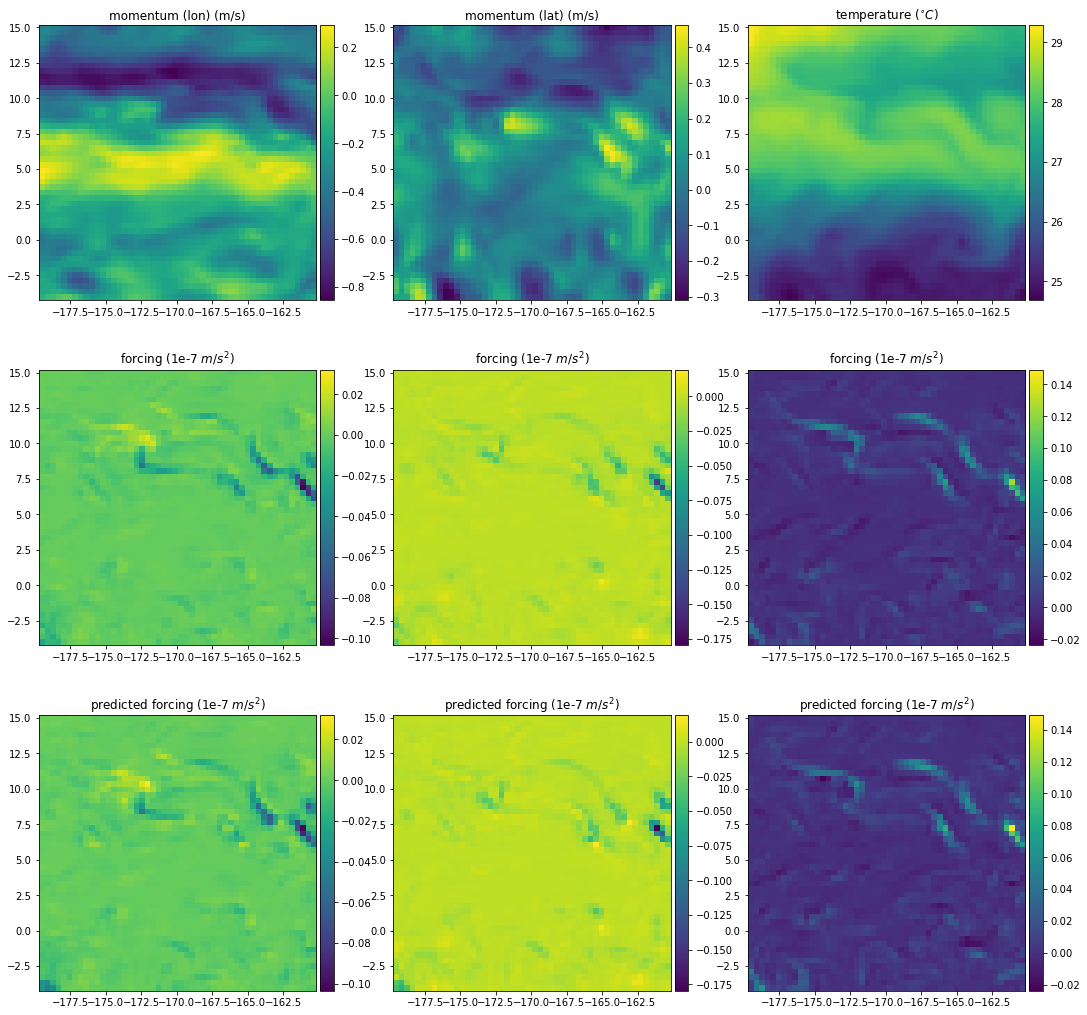

In [16]:
ncols=X_.shape[0]
nrows=len(img)

fig,axs=plt.subplots(nrows,ncols,figsize=(18,18))
titles=[]
titles.append(['momentum (lon) (m/s)','momentum (lat) (m/s)','temperature ($^{\circ}C$)'])
titles.append(['forcing (1e-7 $m/s^2$)']*ncols)
titles.append(['predicted forcing (1e-7 $m/s^2$)']*ncols)


for j in range(nrows):
    for i in range(ncols):
        im=axs[j,i].imshow(img[j][i],\
                            vmin=vmins[j][i],vmax=vmaxs[j][i],extent=[lons[0],lons[-1],lats[0],lats[-1]])
        add_colorbar(im)
        axs[j,i].set_title(titles[j][i])